# in this second version of LSTM I will 

      1° balance train and dev data 
      2° give equal weights to all target classes
      3° increase training  epochs
      4° decrease training  batch size

In [1]:
!pip install nltk

In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import time
import re
import random

# Initialisation du générateur de nombres aléatoires
random.seed(123)

tokenizer = nltk.RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Reshape, SpatialDropout1D
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight



In [3]:
import nltk

# Télécharge les données nécessaires pour le tokenizer (segmenteur) de phrases et de mots
nltk.download('punkt')

# Télécharge la liste de mots vides (stopwords) pour différentes langues
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
train_data = pd.read_csv('cleaned_data/train_cleaned.csv',index_col=0)
dev_data   = pd.read_csv('cleaned_data/dev_cleaned.csv',index_col=0)
test_data  =  pd.read_csv('cleaned_data/test_cleaned.csv',index_col=0)

In [5]:
print("train_data shape",train_data.shape)
print("dev_data shape",dev_data.shape)
print("test_data shape",test_data.shape)

train_data shape (665962, 6)
dev_data shape (100400, 6)
test_data shape (85847, 5)


In [6]:
# GET ONLY 1/4 OF TRAIN AND DEV DATA DUE TO COMPUTATION RESOURCES LIMITATIONS
# train_data = train_data.head(200)
# dev_data = dev_data.head(50)


# Balancing label classes

In [7]:
train_data['note'].value_counts()

7    124656
6     97443
5     94103
9     75903
8     64296
4     58719
3     55285
0     38372
1     30236
2     26949
Name: note, dtype: int64

In [8]:
dev_data['note'].value_counts()

7    18594
6    14333
5    13881
9    12906
8     9945
4     8289
3     8110
0     5835
1     4547
2     3960
Name: note, dtype: int64

In [9]:
# get the same minority classe size in all other classes in train and dev data 

from sklearn.utils import resample, class_weight


# Calculez la taille de la classe minoritaire
train_minority_class_size = min(train_data['note'].value_counts())
dev_minority_class_size = min(dev_data['note'].value_counts())

# Sous-échantillonnez les classes majoritaires pour avoir la même taille que la classe minoritaire
train_data = pd.concat([
    resample(train_data[train_data['note'] == note], replace=True, n_samples=train_minority_class_size)
    for note in train_data['note'].unique()
])

dev_data = pd.concat([
    resample(dev_data[dev_data['note'] == note], replace=True, n_samples=dev_minority_class_size)
    for note in dev_data['note'].unique()
])


In [10]:
train_data['note'].value_counts()

7    26949
6    26949
8    26949
5    26949
1    26949
4    26949
9    26949
3    26949
0    26949
2    26949
Name: note, dtype: int64

In [11]:
dev_data['note'].value_counts()

9    3960
6    3960
7    3960
3    3960
8    3960
5    3960
0    3960
4    3960
1    3960
2    3960
Name: note, dtype: int64

In [7]:
train_data['commentaire'] = train_data['commentaire'].astype(str)
dev_data['commentaire']   = dev_data['commentaire'].astype(str)
test_data['commentaire']  = test_data['commentaire'].astype(str)

# Data Split

In [13]:
X_train = train_data['commentaire']
X_dev = dev_data['commentaire']
X_test = test_data['commentaire']

y_train = train_data['note']
y_dev = dev_data['note']

In [14]:
y_train.unique()

array([7, 6, 8, 5, 1, 4, 9, 3, 0, 2])

In [15]:
y_train

82883     7
445749    7
270622    7
638349    7
502292    7
         ..
635800    2
465938    2
385197    2
496387    2
381008    2
Name: note, Length: 269490, dtype: int64

# Y one hot encoding

In [16]:
y_train_one_hotencoding = to_categorical(y_train, num_classes=10)
print(y_train_one_hotencoding[:10])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [17]:
y_dev_one_hotencoding = to_categorical(y_dev, num_classes=10)
print(y_dev_one_hotencoding[:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [18]:
len(list(X_train.unique()))

212994

# Tokenization

In [19]:
n_most_common_words = 10000
max_len = 180

tokenizer = Tokenizer(num_words=n_most_common_words)
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train) 
X_dev = tokenizer.texts_to_sequences(X_dev)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


X_train = pad_sequences(X_train, maxlen=max_len)
X_dev = pad_sequences(X_dev, maxlen=max_len)

Found 142411 unique tokens.


# Save tokenizer

In [20]:
import pickle

# Sauvegarder le tokenizer
with open('Lstm_tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


# Training

In [21]:
epochs  = 20
emb_dim = 128
batch_size = 32
# batch_size = 128

In [22]:
print((X_train.shape, y_train_one_hotencoding.shape, X_dev.shape, y_dev_one_hotencoding.shape))


((269490, 180), (269490, 10), (39600, 180), (39600, 10))


In [23]:
# Model definition
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X_train.shape[1]))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))


# IMPROVEMENT
# give equal class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# Convert class weights to a dictionary for use with Keras
class_weight_dict = dict(enumerate(class_weights))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Create callbacks
filepath = 'Lstm_best_model_improved.hdf5'
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Increased patience
    restore_best_weights=True
)

callbacks = [checkpoint, early_stopping]

# Training
start_time = time.time()
history = model.fit(X_train, y_train_one_hotencoding, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_dev, y_dev_one_hotencoding), verbose=1, callbacks=callbacks, class_weight=class_weight_dict)
execution_time = time.time() - start_time

print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(execution_time)))

2024-01-04 16:17:51.360493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 180, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 180, 256)          394240    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8422/8422 [==============================] - ETA: 0s - loss: 1.5276 - accuracy: 0.3670
Epoch 2: val_accuracy improved from 0.34212 to 0.35356, saving model to Lstm_best_model_improved.hdf5
8422/8422 [==============================] - 4279s 508ms/step - loss: 1.5276 - accuracy: 0.3670 - val_loss: 1.5881 - val_accuracy: 0.3536
Epoch 3/20
8422/8422 [==============================] - ETA: 0s - loss: 1.4542 - accuracy: 0.3966
Epoch 3: val_accuracy did not improve from 0.35356
8422/8422 [==============================] - 3590s 426ms/step - loss: 1.4542 - accuracy: 0.3966 - val_loss: 1.5816 - val_accuracy: 0.3508
Epoch 4/20
8422/8422 [==============================] - ETA: 0s - loss: 1.3939 - accuracy: 0.4222
Epoch 4: val_accuracy did not improve from 0.35356
8422/8422 [==============================] - 3591s 426ms/step - loss: 1.3939 - accuracy: 0.4222 - val_loss: 1.6092 - val_accuracy: 0.3448
Epoch 5/20
8422/8422 [==============================] - ETA: 0s - loss: 1.3404 - accuracy: 0.4471
E

# save train and validation accuracy/loss

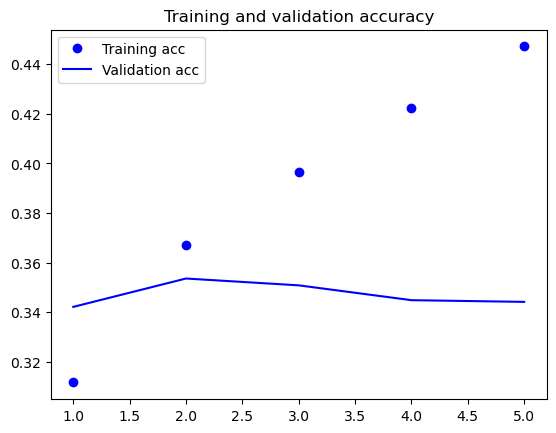

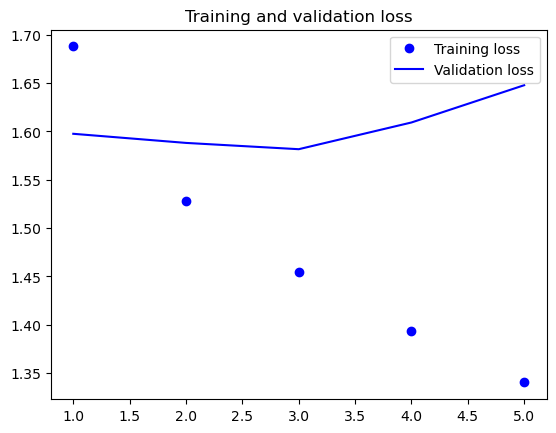

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')  # Save the plot as an image

# Clear the figure for the next plot
plt.figure()

# Plot loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss_plot.png')  # Save the plot as an image


# Test and saving results

In [8]:
# Charger le tokenizer depuis le fichier
import pickle
with open('Lstm_tokenizer.pkl', 'rb') as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)

In [10]:
from tensorflow.keras.models import load_model

# model = load_model('MLP_Best_One.hdf5'),this command doesn't work for me, i had to change the saved model path

modelpath = "C:/trained_Models/Lstm_best_model_improved.hdf5"
max_len = 180


# Load the model with compile=False
Lstm_best_model = load_model(modelpath)

X_test = test_data['commentaire']
# X_test = tokenizer.texts_to_sequences(X_test)
X_test = loaded_tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

predictions = Lstm_best_model.predict(X_test)
argmax_predictions = np.argmax(predictions,axis =1)

print("argmax_predictions: ",argmax_predictions)
 
# # generate the plateform test data format        
with open("LSTM_ID_Prediction_improved.txt", "w") as f:
    for i in range(len(test_data['review_id'])):
        prediction = (argmax_predictions[i] + 1) / 2
        line = f"{test_data['review_id'].iloc[i]} {str(prediction).replace('.', ',')}\n"
        f.write(line)

      

2683/2683 [==============================] - 724s 270ms/step
argmax_predictions:  [3 6 7 ... 6 7 8]
